# 導入套件

In [1]:
import numpy as np
from math import *
from collections import deque
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import bs, dmatrix
from scipy.stats import norm, t
from scipy.optimize import minimize
from sklearn.isotonic import IsotonicRegression, check_increasing
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector, FloatVector
from quadprog import solve_qp
import json
np.random.seed(42)

In [2]:
from module.auto_peak_valley import Peak_Valley_Simu, IsotonicReg, constrained_splines_reg, comprehensive_csr

# 引入R套件

In [3]:
utils = rpackages.importr('utils')
base = importr('base')
# print(base.R_home())
splines = importr("splines")
R_quadprog = importr("quadprog")

# 用單峰資料來測以p-value當決策法則時，peak的偵測效果如何 (auto_peak_points_detection version 3)

In [4]:
# g = lambda x: -x**2
# x1 = np.linspace(-1,1,500).round(5)
# y1 = g(x1) + np.random.randn(500)*0.1
# plt.figure(figsize=(12,8))
# plt.scatter(x1, y1, s=10)
# plt.grid()
# plt.show()

In [5]:
# single_peak = Peak_Valley_Simu()
# single_peak.x, single_peak.y = x1, y1
# single_peak.auto_peakzone_detection(0, estimation_mode=True)

In [6]:
# auto_single_init_demarcation, auto_single_peak_detection_result, auto_single_peak_detection_dict = \
#     single_peak.auto_peak_points_detection_v3(step=0.02, distance=1)
# print(auto_single_peak_detection_result)
# print(auto_single_init_demarcation)

In [7]:
# auto_single_peak_detection_dict[0]

In [8]:
# peak_x1 = list(auto_single_peak_detection_result)
# peak_y1 = y1[[x1.tolist().index(i) for i in peak_x1]]
# plt.figure(figsize=(12,8))
# plt.scatter(x1, y1, s=10)
# plt.scatter(peak_x1, peak_y1, c="r", marker='*')
# plt.grid()
# plt.show()

# 用一個多峰資料來測試自動找peak的程式表現如何

## 畫資料 & 定義類別

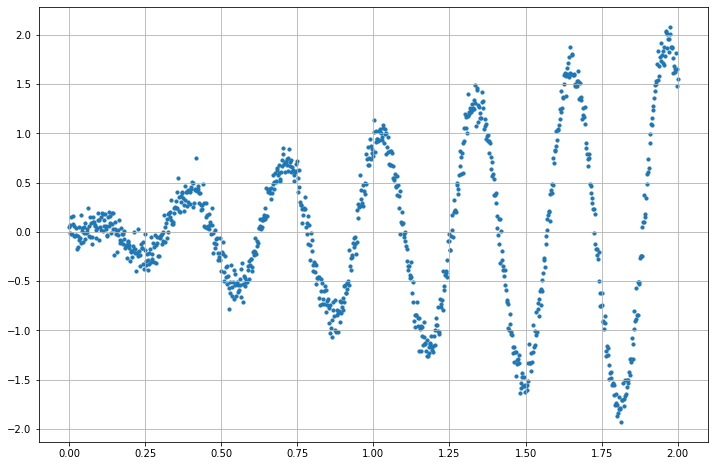

In [9]:
f = lambda x: x*np.sin(20*x)
x = np.linspace(0,2,1000).round(5)
y = f(x) + np.random.randn(1000)*0.1
plt.figure(figsize=(12,8))
plt.scatter(x, y, s=10)
plt.grid()
plt.show()

In [10]:
multi_peak = Peak_Valley_Simu()
multi_peak.x, multi_peak.y = x, y

## auto_peak_points_detection

In [11]:
auto_multi_init_demarcation, auto_multi_peak_detection_result, auto_multi_peak_detection_dict = \
    multi_peak.auto_peak_points_detection_v3(step=0.02, distance=0.1, iter_scale=2)
print(auto_multi_peak_detection_result)
print(auto_multi_init_demarcation)

deque([0.4004, 0.72072, 1.001, 1.31932, 1.63964, 1.95996])
deque([0.72072], maxlen=1)


In [12]:
# auto_multi_peak_detection_dict

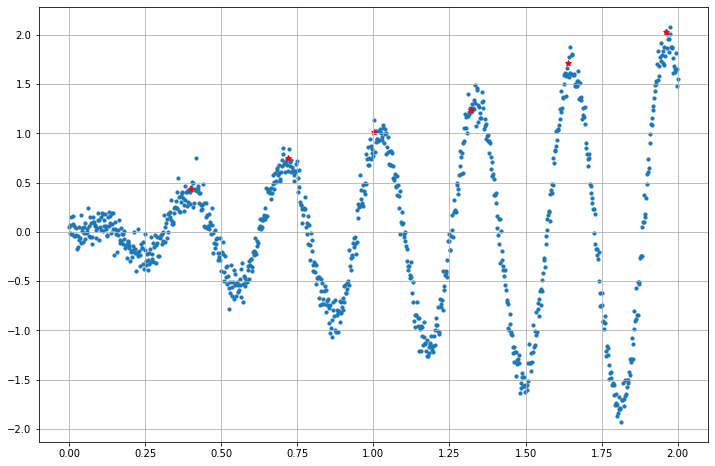

In [13]:
peak_x = list(auto_multi_peak_detection_result)
peak_y = y[[x.tolist().index(i) for i in peak_x]]
plt.figure(figsize=(12,8))
plt.scatter(x, y, s=10)
plt.scatter(peak_x, peak_y, c="r", marker='*')
plt.grid()
plt.show()

## auto_valley_points_detection

In [14]:
auto_multi_initvalley_demarcation, auto_multi_valley_detection_result, auto_multi_valley_detection_dict = \
    multi_peak.auto_valley_points_detection(step=0.02, distance=0.08, iter_scale=0.5)
print(auto_multi_valley_detection_result)
print(auto_multi_initvalley_demarcation)

deque([0.24024, 0.56056, 0.9009, 1.1992, 1.4995, 1.77978])
deque([1.4995], maxlen=1)


In [15]:
# auto_multi_valley_detection_dict

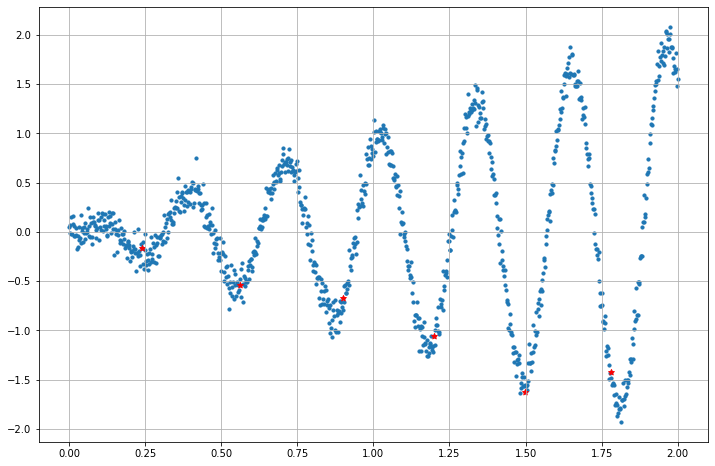

In [16]:
valley_x = list(auto_multi_valley_detection_result)
valley_y = y[[x.tolist().index(i) for i in valley_x]]
plt.figure(figsize=(12,8))
plt.scatter(x, y, s=10)
plt.scatter(valley_x, valley_y, c="r", marker='*')
plt.grid()
plt.show()

## peak and valley 座標和索引

In [17]:
pv, pv_index = multi_peak.peak_valley_index()
print(pv, "\n", pv_index, sep="")

[0.24024, 0.4004, 0.56056, 0.72072, 0.9009, 1.001, 1.1992, 1.31932, 1.4995, 1.63964, 1.77978, 1.95996]
[0, 120, 200, 280, 360, 450, 500, 599, 659, 749, 819, 889, 979, 999]


## sklearn.isotonic.IsotonicRegression

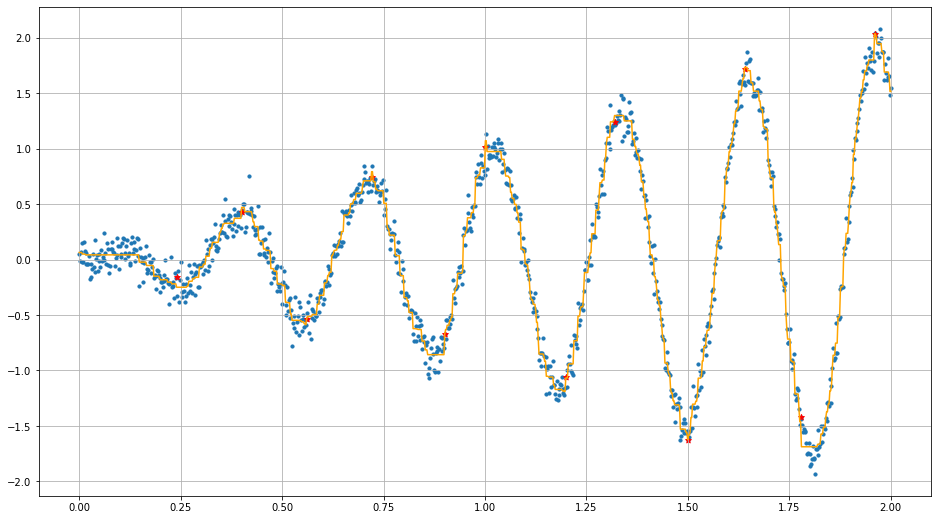

In [18]:
multi_pv_isoreg = IsotonicReg(x=x, y=y, pv_index=pv_index)
multi_pv_isoreg.iso_fit_transform()
multi_pv_isoreg.plot_isoreg()

## 使用AIC判別  $ AIC = n\log{\frac{RSS}{n}} + 2k $ , k是參數數量
## 使用BIC判別  $ BIC = n\log{\frac{RSS}{n}} + k\log{n} $ , k是參數數量

In [19]:
def AIC(n, rss, k):
    return n*log(rss/n) + 2*k
def BIC(n, rss, k):
    return n*log(rss/n) + k*log(n)

In [20]:
print("RSS scikit-learn package: ", multi_pv_isoreg.isotonic_rss())
print("AIC with scikit-learn package: ", AIC(1000, multi_pv_isoreg.isotonic_rss(), len(pv_index)-2))
print("BIC with scikit-learn package: ", BIC(1000, multi_pv_isoreg.isotonic_rss(), len(pv_index)-2))

RSS scikit-learn package:  5.617207977794751
AIC with scikit-learn package:  -5157.92053962723
BIC with scikit-learn package:  -5099.027476279444


# 使用Spline方法取代Isotonic Regression (取一段peak、valley試作)

In [21]:
# knots = list(np.linspace(x[pv_index[5]], x[pv_index[6]], 11)[1:-1])
# bx = bs(x=x[pv_index[5]:pv_index[6]], knots=knots, lower_bound=x[pv_index[5]],
#         upper_bound=x[pv_index[6]], include_intercept=True,
#         degree=2)
# print(bx.shape)
# print(knots)

In [22]:
# BX = None
# def backward_elimination(y, X):
#     global BX
#     BX = X.copy()
#     new_knots = knots.copy()
#     while True:
#         mod = sm.OLS(y, BX)
#         result = mod.fit()
#         if result.pvalues.max() > 0.05:
#             BX = np.delete(BX, result.pvalues.argmax(), axis=1)
#             new_knots.pop(result.pvalues.argmax())
#         else:
#             break

#     return new_knots, result

In [23]:
# new_knots, res1 = backward_elimination(y[pv_index[5]:pv_index[6]], bx)
# # res1.summary()

In [24]:
# print(new_knots, "\n", knots, sep="") # 比較原本節點和修該完顯著的節點

In [25]:
# knots_m_plus_k = [x[pv_index[5]]]*3 + new_knots + [x[pv_index[6]]]*3
# print(knots_m_plus_k, len(knots_m_plus_k), sep="\n")

In [26]:
# for i in range(len(knots_m_plus_k) - 3):
#     if i == 0:
#         basis_func_matrix = splines.splineDesign(knots=FloatVector(knots_m_plus_k[i:i+4]),
#                                                  x=FloatVector(knots_m_plus_k[2:12]),
#                                                  derivs=1, ord=3, outer_ok=True)
#         basis_func_matrix = np.array(basis_func_matrix)
    
#     else:
#         tem_matrix = np.array(splines.splineDesign(knots=FloatVector(knots_m_plus_k[i:i+4]),
#                                                    x=FloatVector(knots_m_plus_k[2:12]),
#                                                    derivs=1, ord=3, outer_ok=True))
#         basis_func_matrix = np.hstack((basis_func_matrix, tem_matrix))

# print(basis_func_matrix.T.shape)

## Minimize $ \frac{1}{2}x^TGx - a^Tx $ subject to $ C^Tx \ge b $

In [27]:
# G = 2*BX.T @ BX
# a = (2* BX.T @ y[pv_index[5]:pv_index[6]])
# C = basis_func_matrix.T
# b = np.zeros((10,))
# print(G.shape, a.shape, C.shape, b.shape)

In [28]:
# solution_c, value_c, unconstrained_solution_c, iterations_c, Lagrangian_c, iact_c = solve_qp(G, a, C, b, meq=0)

In [29]:
# plt.figure(figsize=(12,8))
# plt.plot(x[pv_index[5]:pv_index[6]], BX@solution_c, c="r")
# plt.scatter(x[pv_index[5]:pv_index[6]], y[pv_index[5]:pv_index[6]])
# plt.grid()
# plt.show()

# 整段使用Splines方法取代Isotonic Regression

In [30]:
csr = constrained_splines_reg(x, y, pv_index)
bx_dict, BX_dict, new_knots, bspline_basis_knots = csr.findall_splines_reg_with_backward_elimination()
y_bs_constrained_result = csr.fit_constrained_transform(first_part_increase=False)

In [31]:
RSS_bspline = np.sum((y - y_bs_constrained_result)**2)
print("RSS of b-splines", RSS_bspline)
parameter_k = sum(len(new_knots[i]) for i in range(len(new_knots))) + 12 + 3*13 # 各段顯著節點數量總合 + 12個peak valley + order3乘上13段
print("AIC with piecewise bsplines: ", AIC(1000, RSS_bspline, parameter_k))
print("BIC with piecewise bsplines: ", BIC(1000, RSS_bspline, parameter_k))

RSS of b-splines 8.6156003393431
AIC with piecewise bsplines:  -4442.180726074022
BIC with piecewise bsplines:  -3676.570902552808


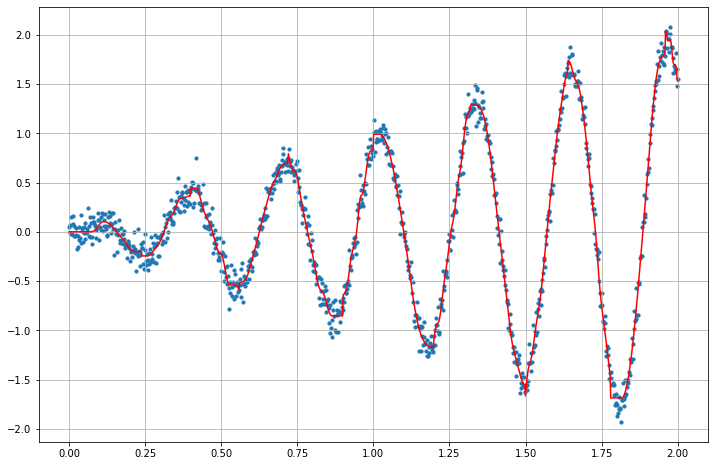

In [32]:
plt.figure(figsize=(12,8))
plt.plot(x, y_bs_constrained_result, c="r")
plt.scatter(x, y, s=10)
plt.grid()
plt.show()

# 最佳化 peak and valley 該選的 distance 大小

## 定義將pv_coordinate轉換成softmax形式的函示

In [33]:
def to_softmax(pv_coordinate): # 正確的 multi-class logistic reg 作法
    pv_coordinate_copy = np.hstack((x[0], np.array(pv), x[-1]))
    pv_coordinate_copy2 = np.diff(pv_coordinate_copy)
    mean = pv_coordinate_copy2.mean()
    log_odds = np.log(pv_coordinate_copy2 / mean)
    return log_odds # array

def reverse_softmax(pv_coordinate, pv_coordinate_diff_log_odds_form): # 正確的 multi-class logistic reg 作法
    pv_coordinate_copy = np.hstack((x[0], np.array(pv_coordinate), x[-1]))
    pv_coordinate_copy2 = pv_coordinate_copy[1:] - pv_coordinate_copy[:-1]
    mean = pv_coordinate_copy2.mean()
    pv_coordinate_diff = np.exp(pv_coordinate_diff_log_odds_form) * mean
    pv_refactor_coordinate = pv_coordinate_diff.cumsum()[:-1]
    nearest_x = [min(x, key=lambda k: abs(k-j)) for j in pv_refactor_coordinate]
    nearest_x_index = [list(x).index(i) for i in nearest_x]
    nearest_x_index = [0] + nearest_x_index + [999]
    return nearest_x_index

def to_softmax_v2(pv_coordinate: list): # 搞錯的 multi-class logistic reg 作法
    pv_coordinate_copy = np.array(pv_coordinate)
    # log_odds = pv_coordinate_copy / pv_coordinate_copy[base_index]
    # output = log_odds / sum(log_odds)
    output = pv_coordinate_copy / sum(pv_coordinate_copy)
    return output*2 # array

def reverse_softmax_v2(pv_coordinate_softmax_form): # 搞錯的 multi-class logistic reg 作法
    pv_coordinate_original_form = 0.72072*(1/pv_coordinate_softmax_form[3])*pv_coordinate_softmax_form
    nearest_x = [min(x, key=lambda k: abs(k-j)) for j in pv_coordinate_original_form]
    nearest_x_index = [list(x).index(i) for i in nearest_x]
    nearest_x_index = [0] + nearest_x_index + [999]
    return nearest_x_index

def to_softmax_v3(pv_coordinate, base=0): # 最終版的 multi-class logistic reg 作法
    pv_coordinate_copy = np.hstack((x[0], np.array(pv_coordinate), x[-1]))
    pv_coordinate_copy2 = np.diff(pv_coordinate_copy)
    log_odds = np.log(pv_coordinate_copy2 / pv_coordinate_copy2[base])
    return log_odds

def reverse_softmax_v3(pv_coordinate_softmax_form): # 最終版的 multi-class logistic reg 作法
    # pv_coordinate_original_form = np.exp(pv_coordinate_softmax_form) * 0.24024
    # pv_coordinate_original_form = pv_coordinate_original_form.cumsum()[:-1]
    pv_coordinate_base_form = 1 / np.sum(np.exp(pv_coordinate_softmax_form))
    pv_coordinate_original_form = np.hstack((pv_coordinate_base_form, pv_coordinate_base_form*np.exp(pv_coordinate_softmax_form[1:]))).cumsum() * 2
    pv_coordinate_original_form = pv_coordinate_original_form[:-1]
    nearest_x = [min(x, key=lambda k: abs(k-j)) for j in pv_coordinate_original_form]
    nearest_x_index = [list(x).index(i) for i in nearest_x]
    nearest_x_index = [0] + nearest_x_index + [999]
    return nearest_x_index

In [34]:
pv_coordinate_softmax = to_softmax(pv)
# print(pv_coordinate_softmax)
# print(reverse_softmax(pv, pv_coordinate_softmax))
# print("\n")

pv_coordinate_softmax_v2 = to_softmax_v2(pv)
# print(pv_coordinate_softmax_v2)
# print(pv_coordinate_softmax_v2.sum())
# print(reverse_softmax_v2(pv_coordinate_softmax_v2))
# print("\n")

# pv_coordinate_softmax_v3 = to_softmax_v3(pv)
# print(pv_coordinate_softmax_v3)
# print(reverse_softmax_v3(pv_coordinate_softmax_v3))

# print(multi_peak.isotonic_reg_rss(pv_coordinate_softmax))
# print(multi_peak.isotonic_reg_rss_v2(pv_coordinate_softmax_v2))
# print(multi_peak.isotonic_reg_rss_v3(pv_coordinate_softmax_v3))

## 第一版的 multi-class logistic reg 作法 (不採用)

In [35]:
# minimize_result = minimize(multi_peak.isotonic_reg_rss, pv_coordinate_softmax, method="Nelder-Mead", options={"adaptive": True})
# np.save(".\\weights\\minimize_result_x", minimize_result.x)

In [36]:
# minimize_result_x = np.load(".\\weights\\minimize_result_x.npy")
# minimize_result_x

In [37]:
# print(reverse_softmax(pv, minimize_result_x))
# print(x[reverse_softmax(pv, minimize_result_x)])

In [38]:
# multi_tuned_pv_isoreg = IsotonicReg(x=x, y=y, pv_index=reverse_softmax(pv, minimize_result_x))
# multi_tuned_pv_isoreg.iso_fit_transform()
# print("RSS: ", multi_tuned_pv_isoreg.isotonic_rss())
# multi_tuned_pv_isoreg.plot_isoreg()

### 經過優化後再用splines方法擬合結果

In [39]:
# csr_optim = constrained_splines_reg(x, y, pv_index=reverse_softmax(minimize_result.x))
# bx_optim, BX_optim, new_knots_optim, bspline_basis_knots_optim = csr_optim.findall_splines_reg_with_backward_elimination()
# y_bs_constrained_result_optim = csr_optim.fit_constrained_transform(first_part_increase=False)

In [40]:
# RSS_bspline_optim = np.sum((y - y_bs_constrained_result_optim)**2)
# print(RSS_bspline_optim)
# parameter_k_optim = sum(len(new_knots_optim[i]) for i in range(len(new_knots_optim))) + 12 + 3*13
# print("AIC with piecewise bsplines: ", AIC(1000, RSS_bspline_optim, parameter_k_optim))
# print("BIC with piecewise bsplines: ", BIC(1000, RSS_bspline_optim, parameter_k_optim))

In [41]:
# plt.figure(figsize=(12,8))
# plt.plot(x, y_bs_constrained_result_optim, c="r")
# plt.scatter(x, y, s=10)
# plt.grid()
# plt.show()

## 搞錯的 multi-class logistic reg 作法

In [42]:
minimize_result2 = minimize(multi_peak.isotonic_reg_rss_v2, pv_coordinate_softmax_v2, method="Nelder-Mead", options={"adaptive": True})
# np.save(".\\weights\\minimize_result2_x", minimize_result2.x)

c:\Users\Jater\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\isotonic.py:70: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn(
c:\Users\Jater\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\isotonic.py:70: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn(
c:\Users\Jater\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\isotonic.py:70: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn(
c:\Users\Jater\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\isotonic.py:70: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn(
c:\Users\Jater\A

In [43]:
minimize_result2_x = np.load(".\\weights\\minimize_result2_x.npy")
minimize_result2_x

array([0.03706631, 0.06321698, 0.08267722, 0.10863757, 0.13237845,
       0.15506227, 0.17794847, 0.20205146, 0.22625466, 0.2481863 ,
       0.27325909, 0.29780033])

In [44]:
new_pv = x[reverse_softmax_v2(minimize_result2_x)]
new_pv_index = reverse_softmax_v2(minimize_result2_x)
print(new_pv)
print(new_pv_index)

[0.      0.24625 0.41842 0.54855 0.72072 0.87888 1.02903 1.18118 1.34134
 1.5015  1.64565 1.81381 1.97598 2.     ]
[0, 123, 209, 274, 360, 439, 514, 590, 670, 750, 822, 906, 987, 999]


RSS:  4.952899249909615


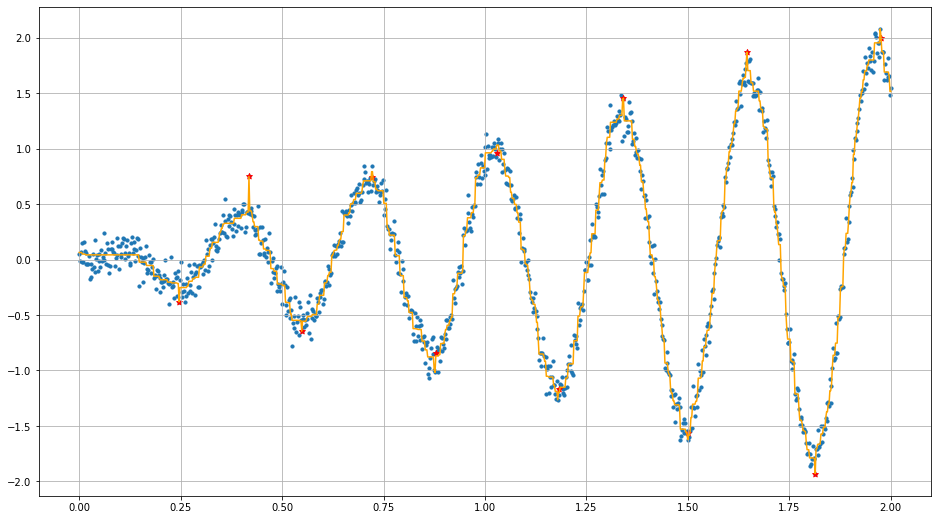

In [45]:
multi_tuned_pv_isoreg2 = IsotonicReg(x=x, y=y, pv_index=new_pv_index)
multi_tuned_pv_isoreg2.iso_fit_transform()
print("RSS: ", multi_tuned_pv_isoreg2.isotonic_rss())
multi_tuned_pv_isoreg2.plot_isoreg()

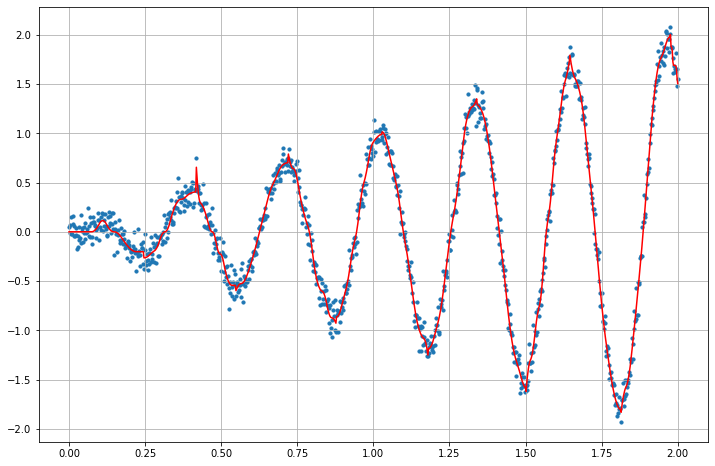

In [46]:
csr_optim2 = constrained_splines_reg(x, y, pv_index=new_pv_index)
bx_optim2, BX_optim2, new_knots_optim2, bspline_basis_knots_optim2 = csr_optim2.findall_splines_reg_with_backward_elimination()
y_bs_constrained_result_optim2 = csr_optim2.fit_constrained_transform(first_part_increase=False)

plt.figure(figsize=(12,8))
plt.plot(x, y_bs_constrained_result_optim2, c="r")
plt.scatter(x, y, s=10)
plt.grid()
plt.show()

In [47]:
# csr_optim2.Solve_QP()

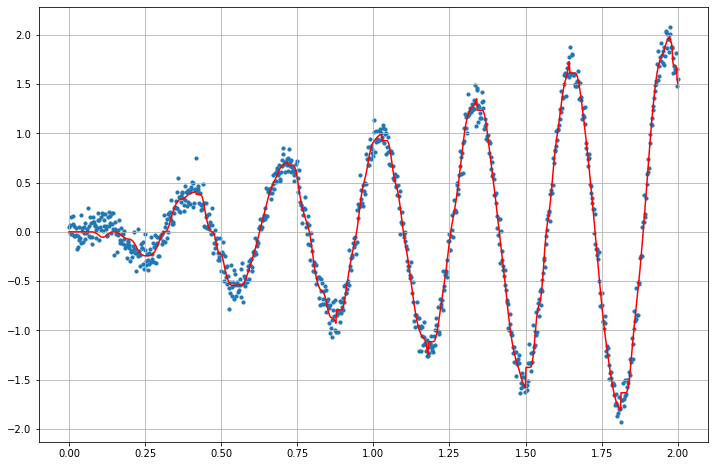

In [48]:
# 這邊是錯誤bspline加限制式結果，constrained_splines_reg改良結果為comprehensive_csr
csr_optim2_re = constrained_splines_reg(x, y, pv_index=new_pv_index)
bx_optim2_re, BX_optim2_re, new_knots_optim2_re, bspline_basis_knots_optim2_re = csr_optim2_re.findall_splines_reg_with_backward_elimination()
y_bs_constrained_result_optim2_re = csr_optim2_re.fit_constrained_transform(meq=2, first_part_increase=False)

plt.figure(figsize=(12,8))
plt.plot(x, y_bs_constrained_result_optim2_re, c="r")
plt.scatter(x, y, s=10)
plt.grid()
plt.show()

In [49]:
new_knots_optim2_re_flatten = []
for i in new_knots_optim2_re:
    for j in i:
        new_knots_optim2_re_flatten.append(j)
print(len(new_knots_optim2_re_flatten))

98


In [50]:
# csr_optim2_re.Solve_QP()

In [51]:
# BX_optim2_re
# new_knots_optim2_re
# bspline_basis_knots_optim2_re

## 最終版的 multi-class logistic reg 作法
把 new_pv[1:-1] 結果代入重新優化的結果

In [52]:
pv_coordinate_softmax_v3 = to_softmax_v3(new_pv[1:-1])
print(pv_coordinate_softmax_v3)
print(reverse_softmax_v3(pv_coordinate_softmax_v3))

[ 0.         -0.35786492 -0.63781333 -0.35786492 -0.4427401  -0.49471249
 -0.4814804  -0.43017396 -0.43017396 -0.53549286 -0.38143137 -0.41770211
 -2.32746046]
[0, 123, 209, 274, 360, 439, 514, 590, 670, 750, 822, 906, 987, 999]


In [53]:
# minimize_result3 = minimize(multi_peak.isotonic_reg_rss_v3, pv_coordinate_softmax_v3, method="Nelder-Mead", options={"adaptive": True})
# np.save(".\\weights\\minimize_result_final_x", minimize_result3.x)
minimize_result3_x = np.load(".\\weights\\minimize_result_final_x.npy")

In [54]:
minimize_result3_x

array([ 1.97756653e-05, -3.56570713e-01, -6.37958755e-01, -3.59102756e-01,
       -4.46194044e-01, -4.90844109e-01, -4.95433401e-01, -4.30787929e-01,
       -4.31129040e-01, -5.36048881e-01, -3.82939985e-01, -4.17895077e-01,
       -2.33666588e+00])

In [55]:
print(reverse_softmax_v3(minimize_result3_x))
print(to_softmax_v3(x[reverse_softmax_v3(minimize_result3_x)][1:-1]))

[0, 123, 209, 275, 361, 439, 515, 590, 670, 750, 822, 906, 987, 999]
[ 0.         -0.35786492 -0.62256099 -0.35786492 -0.45546616 -0.4814804
 -0.49471249 -0.43017396 -0.43017396 -0.53549286 -0.38143137 -0.41770211
 -2.32746046]


RSS:  4.9408514521325255


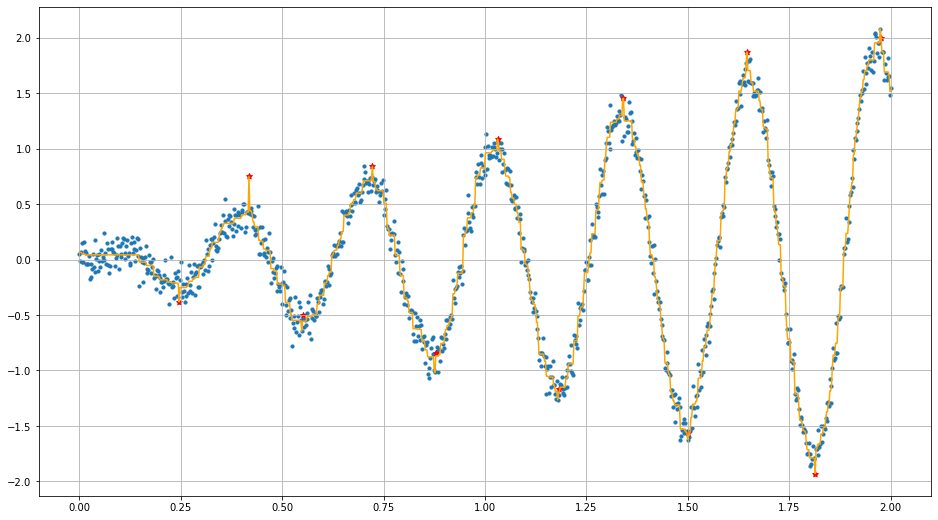

In [56]:
multi_tuned_pv_isoreg3 = IsotonicReg(x=x, y=y, pv_index=reverse_softmax_v3(minimize_result3_x))
multi_tuned_pv_isoreg3.iso_fit_transform()
print("RSS: ", multi_tuned_pv_isoreg3.isotonic_rss())
multi_tuned_pv_isoreg3.plot_isoreg()

# 將所有節點和峰谷當作knots重新smoothing

In [57]:
comprehensive_knots = []
for i in new_knots_optim2_re:
    for j in i:
        comprehensive_knots.append(j)
comprehensive_knots += pv
comprehensive_knots.sort()
print(len(comprehensive_knots))

110


In [58]:
comprehensive_bx = bs(x=x, knots=comprehensive_knots, degree=2, include_intercept=True, lower_bound=0, upper_bound=2)
print(comprehensive_bx.shape)

(1000, 113)


In [59]:
pv_index_in_compre_knots = []
for i in pv:
    pv_index_in_compre_knots.append(comprehensive_knots.index(i))
print([0] + pv_index_in_compre_knots + [112])

[0, 2, 9, 18, 27, 37, 44, 55, 62, 72, 81, 89, 100, 112]


In [60]:
# comprehensive_knots

In [61]:
compre_csr = comprehensive_csr(x=x, y=y, pv_coordinate=new_pv[1:-1], pv_index=new_pv_index, knots_of_each_part=new_knots_optim2_re_flatten)

In [62]:
(compre_csr.splineDesign_derivative_func_Matrix(deg=2)).shape

(112, 113)

In [63]:
G, a, C, b = compre_csr.generate_GaCb_matrix(deg=2, first_part_increase=False)
print(G.shape, a.shape, C.shape, b.shape) # shape of x vector: (113, 1)

(113, 113) (113,) (113, 112) (112,)


In [64]:
compre_csr.Solve_QP(deg=2, meq=12, first_part_increase=False)

array([ 0.04217238,  0.04217238, -0.01652537, -0.2589418 , -0.2589418 ,
       -0.22003256, -0.15490854, -0.04557682,  0.23535492,  0.35488088,
        0.35583363,  0.44720083,  0.44720083,  0.23765444,  0.15610778,
        0.06829726, -0.17714371, -0.39929491, -0.54970322, -0.54970322,
       -0.54970322, -0.52670355, -0.38266235, -0.21940558,  0.02162478,
        0.32344273,  0.54767378,  0.65529854,  0.70220041,  0.70220041,
        0.64129524,  0.3211426 ,  0.16265687, -0.07327785, -0.56676465,
       -0.61670176, -0.87637295, -0.87637295, -0.87637295, -0.68487918,
       -0.49320518, -0.21926801,  0.09368333,  0.49634954,  0.85470212,
        0.94296526,  0.99992452,  0.99992452,  0.79358728,  0.60269723,
        0.37346316,  0.03005823, -0.42180365, -0.94688499, -1.02979652,
       -1.18427061, -1.18427061, -1.00260201, -0.82144039, -0.40225232,
       -0.04788024,  0.42110073,  1.07599072,  1.25625257,  1.29862108,
        1.29862108,  1.14838931,  0.86537319,  0.43455924, -0.01

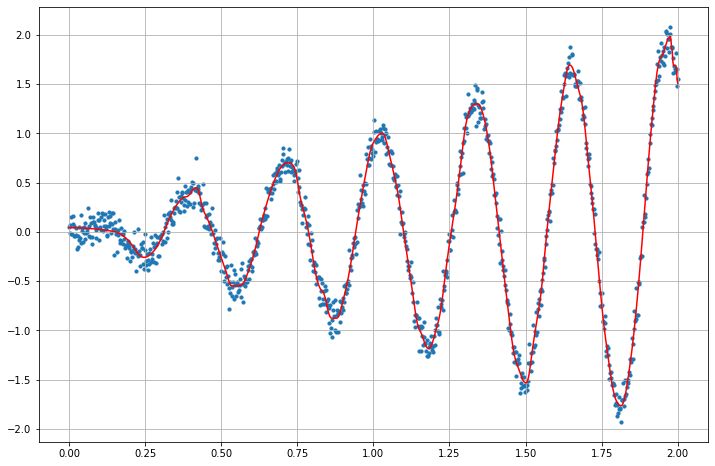

In [65]:
y_bs_compre_constrained_result = compre_csr.fit_constrained_transform(deg=2, meq=12, first_part_increase=False)

plt.figure(figsize=(12,8))
plt.plot(x, y_bs_compre_constrained_result, c="r")
plt.scatter(x, y, s=10)
plt.grid()
plt.show()

In [66]:
print(compre_csr.pv_index_in_compre_knots)

[3, 11, 19, 28, 37, 46, 55, 64, 73, 82, 92, 101]


# 利用老師給的knots重新評估

In [67]:
knots_zm = [0.907910, 0.824825, 0.968970, 0.743745, 0.668670, 0.592595,
            0.513515, 0.447445, 0.361360, 0.875875, 0.282280, 0.775775,
            0.415415, 0.213215, 0.700700, 0.560560, 0.135135, 0.481480,
            0.635635, 0.329330, 0.074075, 0.176175, 0.250250, 0.020020]
knots_zm = np.array(knots_zm) * 2
knots_zm = knots_zm.tolist()

In [68]:
compre_csr_zm = comprehensive_csr(x=x, y=y, pv_coordinate=new_pv[1:-1], pv_index=new_pv_index, knots_of_each_part=knots_zm)

In [69]:
print(compre_csr_zm.splineDesign_derivative_func_Matrix(deg=2).shape)

(38, 39)


In [70]:
print(compre_csr_zm.pv_index_in_compre_knots)

[3, 6, 9, 12, 15, 19, 21, 25, 28, 30, 33, 36]


In [71]:
print(len(compre_csr_zm.comprehensive_knots()), "\n", compre_csr_zm.comprehensive_knots(), sep="")

36
[0.04004, 0.14815, 0.24625, 0.27027, 0.35235, 0.41842, 0.42643, 0.5005, 0.54855, 0.56456, 0.65866, 0.72072, 0.72272, 0.83083, 0.87888, 0.89489, 0.96296, 1.02703, 1.02903, 1.12112, 1.18118, 1.18519, 1.27127, 1.33734, 1.34134, 1.4014, 1.48749, 1.5015, 1.55155, 1.64565, 1.64965, 1.75175, 1.81381, 1.81582, 1.93794, 1.97598]


In [72]:
print(compre_csr_zm.pv)
print(compre_csr_zm.pv_index)

[0.24625, 0.41842, 0.54855, 0.72072, 0.87888, 1.02903, 1.18118, 1.34134, 1.5015, 1.64565, 1.81381, 1.97598]
[0, 123, 209, 274, 360, 439, 514, 590, 670, 750, 822, 906, 987, 999]


In [73]:
G, a, C, b = compre_csr_zm.generate_GaCb_matrix(deg=2, first_part_increase=False)
print(G.shape, a.shape, C.shape, b.shape)

(39, 39) (39,) (39, 38) (38,)


In [74]:
np.all(np.linalg.eigvals(G)>0)

True

In [75]:
tmp_qp_solve = compre_csr_zm.Solve_QP(deg=2, meq=12, first_part_increase=False)
print(tmp_qp_solve)
tmp_solution = compre_csr_zm.splineDesign_derivative_xi_Matrix(deg=2, xi=x) @ tmp_qp_solve
print(tmp_solution.shape)

[ 0.06802228  0.06802228  0.06802228 -0.18881536 -0.18881536 -0.03673035
  0.43273119  0.43273119  0.09414507 -0.56311141 -0.56311141 -0.25073955
  0.76084819  0.76084819  0.14067392 -0.9181923  -0.9181923  -0.22607925
  0.9091599   0.9091599   0.9091599  -1.2446119  -1.2446119  -0.82001404
  1.2712585   1.30378637  1.30378637 -1.08653147 -1.55459145 -1.55459145
  1.50658317  1.50658317  1.32745193 -1.93266158 -1.93266158 -0.24127173
  2.0852147   2.0852147   1.37563551]
(1000,)


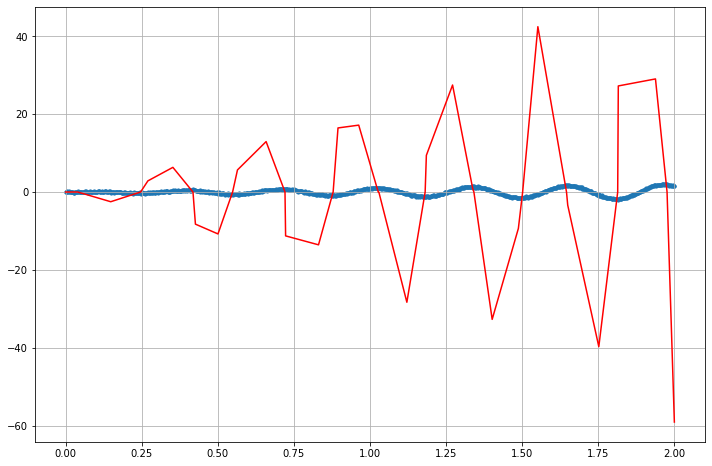

In [76]:
plt.figure(figsize=(12,8))
plt.plot(x, tmp_solution, c="r")
plt.scatter(x, y, s=10)
plt.grid()
plt.show()

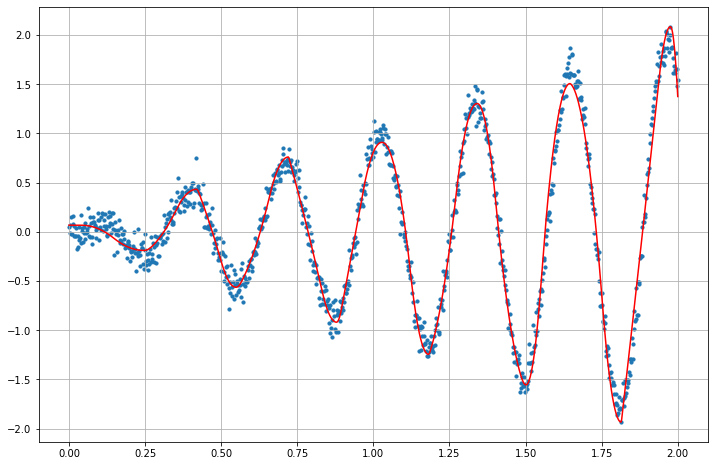

In [77]:
y_zm_constrained_result = compre_csr_zm.fit_constrained_transform(deg=2, meq=12, first_part_increase=False)

plt.figure(figsize=(12,8))
plt.plot(x, y_zm_constrained_result, c="r")
plt.scatter(x, y, s=10)
plt.grid()
plt.show()

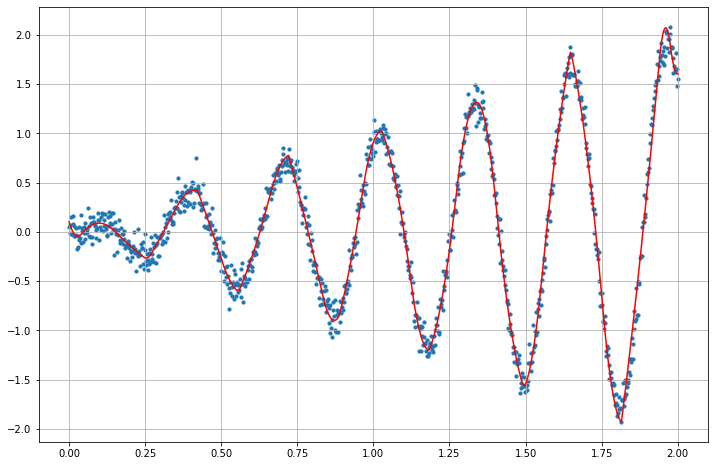

In [78]:
plt.figure(figsize=(12,8))
plt.plot(x, compre_csr_zm.fit_transform(deg=2), c="r")
plt.scatter(x, y, s=10)
plt.grid()
plt.show()